In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const

Nuclear Radius:  8.347824740841165
Turning point: 26.385940247609497 fm
Number of regions: 102
Potentials: [-134.           27.69095494   26.56710652   25.53092383   24.57253436
   23.6834944    22.85653953   22.08538571   21.36456927   20.68931732
   20.05544185   19.45925287   18.89748648   18.3672451    17.8659475
   17.39128675   16.94119475   16.51381206   16.1074623    15.7206301
   15.35194225   15.00015141   14.66412203   14.34281805   14.03529229
   13.74067709   13.45817615   13.18705734   12.92664635   12.67632111
   12.43550681   12.20367152   11.98032224   11.76500141   11.5572838
   11.35677368   11.16310231   10.97592569   10.79492249   10.61979227
   10.45025374   10.28604332   10.1269137     9.97263269    9.822982
    9.67775627    9.53676209    9.39981718    9.26674956    9.13739687
    9.01160568    8.92087655    8.86319458    8.80625376    8.75003988
    8.69453913    8.63973802    8.58562339    8.53218243    8.47940264
    8.42727183    8.37577809    8.32490982    

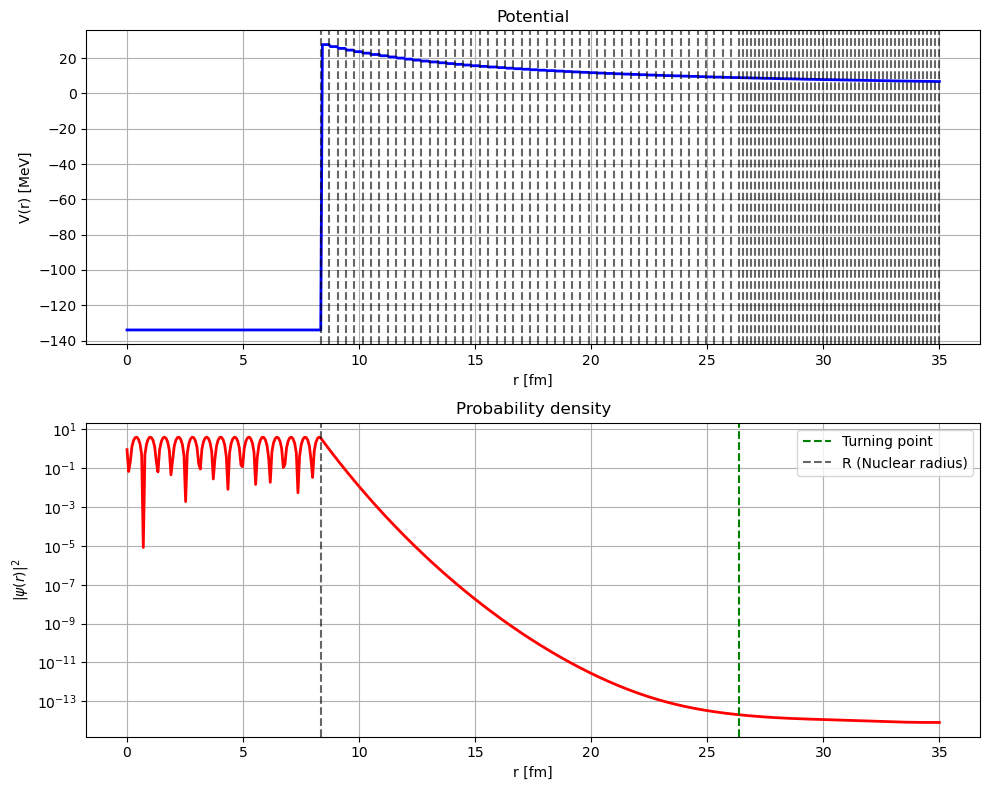

In [ ]:
# Constants
hbarc = 197.3269631  
amu_to_MeV = 931.493614838475  
M_alpha_amu = 4
M_D_amu = 208
M_alpha = M_alpha_amu * amu_to_MeV  
M_D = M_D_amu * amu_to_MeV
mu = (M_alpha * M_D) / (M_alpha + M_D)
E = 8.95    
V0 = 134.0  
alpha_fs = 1 / 137.035999
R = 1.4 * (212 ** (1/3)) 
print("Nuclear Radius: ", R)
r_max = 35  
Z_D = 82
Z_alpha = 2


##################################################
r_turn = alpha_fs * Z_D * Z_alpha * hbarc / E
print("Turning point:", r_turn, "fm")

N_forbidden = 50  
N_allowed   = 50  

boundaries_forbidden = np.linspace(R, r_turn, N_forbidden, endpoint=False)
boundaries_allowed = np.linspace(r_turn, r_max, N_allowed + 1)
boundaries = np.concatenate((boundaries_forbidden, boundaries_allowed))
N_regions = len(boundaries) + 1  
print("Number of regions:", N_regions)


####################################################
potentials = np.empty(N_regions)
potentials[0] = -V0 
for i in range(1, N_regions):
    r_left = boundaries[i - 1]
    if i < len(boundaries):
        r_right = boundaries[i]
        r_mid = 0.5 * (r_left + r_right)
    else:
        r_mid = boundaries[i - 1]
    potentials[i] = (alpha_fs *  Z_D * Z_alpha * hbarc) / r_mid

print("Potentials:", potentials)


####################################################
def calc_k(E, V):
    if E >= V:
        return np.sqrt(2 * mu * (E - V)) / hbarc
    else:
        return 1j * np.sqrt(2 * mu * (V - E)) / hbarc

k_list = np.array([calc_k(E, V) for V in potentials])



####################################################
# Dictionary to keep track of the coefficients
unknown_map = {} 
index = 0
# Region 1:
unknown_map[(1, 'B')] = index  
index += 1
# Regions 2:
for i in range(2, N_regions):
    unknown_map[(i, 'A')] = index
    index += 1
    unknown_map[(i, 'B')] = index
    index += 1
# Region 3:
unknown_map[(N_regions, 'A')] = index
index += 1
n_unknown = index



###################################################
# Matrixxx
n_eq = 2 * (N_regions - 1)
M = np.zeros((n_eq, n_unknown), dtype=complex)
b_vec = np.zeros(n_eq, dtype=complex)

for i in range(1, N_regions):
    x_int = boundaries[i - 1]
    kL = k_list[i - 1]  # k left 
    kR = k_list[i]      # k right 
    row_cont = 2 * (i - 1)  
    row_deriv = row_cont + 1  

    # normal
    if i == 1:
        fixed_term = np.exp(1j * kL * x_int)
        b_vec[row_cont] = -fixed_term
        M[row_cont, unknown_map[(1, 'B')]] = np.exp(-1j * kL * x_int)
    else:
        M[row_cont, unknown_map[(i, 'A')]] = np.exp(1j * kL * x_int)
        M[row_cont, unknown_map[(i, 'B')]] = np.exp(-1j * kL * x_int)
    
    if i + 1 == N_regions:
        M[row_cont, unknown_map[(N_regions, 'A')]] = -np.exp(1j * kR * x_int)
    else:
        M[row_cont, unknown_map[(i + 1, 'A')]] = -np.exp(1j * kR * x_int)
        M[row_cont, unknown_map[(i + 1, 'B')]] = -np.exp(-1j * kR * x_int)
    
    # derivada
    if i == 1:
        fixed_term = 1j * kL * np.exp(1j * kL * x_int)
        b_vec[row_deriv] = -fixed_term
        M[row_deriv, unknown_map[(1, 'B')]] = -1j * kL * np.exp(-1j * kL * x_int)
    else:
        M[row_deriv, unknown_map[(i, 'A')]] = 1j * kL * np.exp(1j * kL * x_int)
        M[row_deriv, unknown_map[(i, 'B')]] = -1j * kL * np.exp(-1j * kL * x_int)
    
    if i + 1 == N_regions:
        M[row_deriv, unknown_map[(N_regions, 'A')]] = -1j * kR * np.exp(1j * kR * x_int)
    else:
        M[row_deriv, unknown_map[(i + 1, 'A')]] = -1j * kR * np.exp(1j * kR * x_int)
        M[row_deriv, unknown_map[(i + 1, 'B')]] = 1j * kR * np.exp(-1j * kR * x_int)


X = np.linalg.solve(M, b_vec)

# Get coeffs
coeffs = {}
coeffs[(1, 'A')] = 1.0   
coeffs[(1, 'B')] = X[unknown_map[(1, 'B')]]
for i in range(2, N_regions):
    coeffs[(i, 'A')] = X[unknown_map[(i, 'A')]]
    coeffs[(i, 'B')] = X[unknown_map[(i, 'B')]]
coeffs[(N_regions, 'A')] = X[unknown_map[(N_regions, 'A')]]
coeffs[(N_regions, 'B')] = 0.0



#############################################################################
F_trans = coeffs[(N_regions, 'A')]
A_trans = coeffs[(1, 'A')]
T_coeff = np.abs(F_trans / A_trans)**2 * (np.real(k_list[-1]) / np.real(k_list[0]))
R_coeff = np.abs(coeffs[(1, 'B')])**2
print("Transmission coefficient T =", T_coeff)
print("Reflection coefficient R =", R_coeff)
print("T + R =", T_coeff + R_coeff)




##############################################################################
v_alpha = np.sqrt((2 * E) / M_alpha) * const.c * 1e15  
v_rel = v_alpha * (1 + (M_alpha / M_D))
tau = 2 * R / (v_rel * T_coeff)
t_half = np.log(2) * tau
print("Lifetime tau =", tau)
print("Half-life t1/2 =", t_half)




###############################################################################
def region_index(x, boundaries):
    return np.searchsorted(boundaries, x)

def V_of_x(x):
    idx = region_index(x, boundaries)
    return potentials[idx]

def psi(x):
    idx = region_index(x, boundaries)
    region = idx + 1
    if region == 1:
        A = coeffs[(1, 'A')]
        B = coeffs[(1, 'B')]
    elif region < N_regions:
        A = coeffs[(region, 'A')]
        B = coeffs[(region, 'B')]
    else:
        A = coeffs[(N_regions, 'A')]
        B = 0.0
    k_val = k_list[idx]
    return A * np.exp(1j * k_val * x) + B * np.exp(-1j * k_val * x)




####################################################################
x_vals = np.linspace(0, r_max, 500)
V_vals = np.array([V_of_x(x) for x in x_vals])
psi_vals = np.array([psi(x) for x in x_vals])
psi_sq = np.abs(psi_vals)**2

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(x_vals, V_vals, 'b-', lw=2)
plt.xlabel("r [fm]")
plt.ylabel("V(r) [MeV]")
plt.title("Potential")
for b in boundaries:
    plt.axvline(x=b, color='k', linestyle='--', alpha=0.6)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogy(x_vals, psi_sq, 'r-', lw=2)
plt.axvline(r_turn, color='g', linestyle='--', label= f'Turning point')
plt.xlabel("r [fm]")
plt.ylabel(r"$|\psi(r)|^2$")
plt.title("Probability density")
plt.axvline(x=R, color='k', linestyle='--', alpha=0.6, label= 'R (Nuclear radius)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()